# 100hz Model evaluation

### Imports

In [1]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
import os
import scipy.io as sio
import xgboost as xgb
import seaborn as sn

In [2]:
quick_load = True

### IO data cleaning

**This is a very intricate function and should be used with caution**
* This function goes through each .hea file and deletes the .mat extension that was causing errors in the reading.

In [3]:
if(not quick_load):

    folder_path = "../../data/WFDB/"
    # Loops thorugh the .hea files and re formats them according to WFDB standards. This dataset included a .mat file type at the end and thew an error. 
    # This loop modifies the .hea files by only removing the .mat text if its found on the line. 

    for filename in os.listdir(folder_path):
        if filename.endswith(".hea"):
            file_path = os.path.join(folder_path, filename)
            
            # Read the contents of the .hea file
            with open(file_path, 'r') as file:
                lines = file.readlines()
            
            # Adjust and format the header lines to remove ".mat" at the end
            adjusted_lines = []
            for line in lines:
                adjusted_line = line.replace(".mat", "")
                adjusted_lines.append(adjusted_line)
            
            # Write the adjusted lines back to the .hea file
            with open(file_path, 'w') as file:
                file.writelines(adjusted_lines)

### Data Loading
* Mat loader: Loads the .mat files independently. Only keeps ecgs with shape (12, 5000) to prevent data mismatch.
* Header Loader: Loads .hea files independently. Uses the wfdb rdheader function to produce a dictionary. 
* Joint function: Loads both the .mat and corresponding header file given that the mat file is of shape (12, 5000)

In [4]:
import os
import numpy as np
import wfdb
import tensorflow as tf
import traceback

if(not quick_load):
    folder_path = "../../data/WFDB/"

    def wfdb_mat_load(path):
        data = []
        for filename in os.listdir(path):
            if filename.endswith(".mat"):
                record_data = sio.loadmat(os.path.join(path, filename))
                if(record_data['val'].shape == (12,5000)):
                    data.append(np.array(record_data['val']))
        return data


    def wfdb_hea_load(path):
        hea_files = []
        for filename in os.listdir(path):
            if filename.endswith(".hea"):
                base_name, file_type = os.path.splitext(filename)
                file_path = os.path.join(path, base_name)
                header = wfdb.rdheader(path+base_name)
                hea_files.append(header)
        return hea_files

    # Incorporates both loading functions so that any data excluded from X is removed from the corresponding Y.
    def wfdb_loader(path):
        data = []    
        hea_files = []
        for filename in os.listdir(path):
            if filename.endswith(".mat"):
                record_data = sio.loadmat(os.path.join(path, filename)) # First handles the .mat file
                if record_data['val'].shape == (12, 5000):
                    data.append(np.array(record_data['val']))
                    header = wfdb.rdheader(path + filename.split(".")[0]) # Switches to .hea file
                    hea_files.append(header)
        
        return (tf.cast(tf.transpose(np.array(data), perm=[0, 2, 1])
    , dtype=tf.float64)/500), hea_files


    sampling_rate = 100

    # Load raw signal data
    with tf.device('/CPU:0'):
        X_nan, Y_raw = wfdb_loader(folder_path)


### Further Data Processing

Converts the raw header data into a Pandas Dataframe. Becomes usable in the form of columns.

In [5]:
if(not quick_load):
    Y_nan = []
    for hea in Y_raw:
        metadata = {}
        for line in hea.comments[0:]:
            key, value = line.strip("#").split(":")
            metadata[key.strip()] = value.strip()
        Y_nan.append(metadata)

    Y_nan = pd.DataFrame(Y_nan)
    Y_nan

#### Filtering
* Excludes NaN values in the age columns.
* Only keeps ecgs under age 89

In [6]:
if(not quick_load):
    with tf.device("/CPU:0"):
        Y_temp = (Y_nan[Y_nan.Age.values != 'NaN'])
        valid_inds = Y_temp.Age.values.astype(int) < 89
        Y = Y_temp[valid_inds]
        X = (X_nan[Y_nan.Age.values != 'NaN'])[valid_inds]

    Y.shape, X.shape

### Downsampling
* The raw ecg data is sampled at 500hz.
* There is a way to preserve curcial information from the ecg while reducing the samplig rate. 
* Scipy signal resampling function

In [7]:
if(not quick_load):
    from scipy import signal
    with tf.device('/CPU:0'):
        resamp_ratio = 100/500
        X_downsampled = signal.resample(X, 1000, axis=1)

    X_downsampled.shape

### Data Augmentation
* We must apply the same transformations as we did on the original dataset

In [8]:
import numpy as np
from scipy import signal

def normalize(X, shape = False):
    # Compute mean and standard deviation along axis 1 and 2
    X_mean = np.mean(X)
    X_std = np.std(X)

    if(shape):
        print(X.shape)
    # Normalize data by subtracting mean and dividing by standard deviation
    return ((X - X_mean) / X_std)

#____________________________________________________________________________________#

bld = 0.5
def baseline_drift(X, baseline, range = 0):
    bld_range = (baseline-range, baseline+range)
    random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
    return X + random_shifts

#____________________________________________________________________________________#

# Define the filter parameters
fs = 100  # Sampling frequency (Hz)
lowcut = 0.5  # Lower cutoff frequency (Hz)
highcut = 40.0  # Higher cutoff frequency (Hz)
filter_order = 4  # Filter order

def bandpass(X, fs, lowcut, highcut, filter_order):
    # Apply bandpass filter to each channel
    filtered_data = np.zeros_like(X)
    for i in range(X.shape[2]):
        for j in range(X.shape[0]):
            b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
            filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

    # Print the shape of the filtered data
    return filtered_data

#____________________________________________________________________________________#

def da_apply(X, functions, shape = False):
    X_final = X.copy()

    # Applys DA Augments in specified order
    for func_dict in functions:
        func = func_dict['func']
        if(func_dict['params'] == None):
            X_final = func(X_final)     
        else:
            params = func_dict['params']
            X_final = func(X_final, *params)  

    if(shape == True):
        print(X_final.shape)

    return X_final

#func_dict = [{'func': normalize, 'params': [None]}]

#func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]

# func_dict =[{'func': normalize, 'params': [None]},
#             {'func': bandpass, 'params': [100, 0.5, 10, 3]}, # 100, 0.5, 10, 3
#             {'func': baseline_drift, 'params': [0,0.075]}]

In [9]:
if(not quick_load):
    with tf.device('/CPU:0'):
        func_dict =[{'func': normalize, 'params': [None]},  # Normalizing across the entire data set instead of by lead
                    {'func': baseline_drift, 'params': [0,0.075]}]  # I found that simulating a 0.075 drift works best

        X_final = da_apply(X_downsampled, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X

In [11]:
if(quick_load):
    Y = pd.read_csv('../../data/georgia_Y_cleaned.csv')
    X_final = np.load('../../data/georgia_X_cleaned.npy')

#### Data visualization

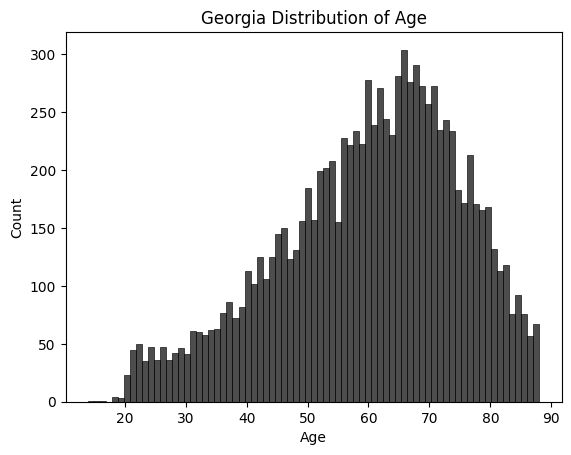

In [12]:
y_filtered = Y[Y.Age.values.astype(int) < 89]


sn.histplot(y_filtered.Age.values.astype(int), bins = 75, color="#111111")
# Adding labels and title
plt.ylabel('Count')
plt.xlabel('Age')
plt.title('Georgia Distribution of Age')

# Show the plot
plt.show()

Text(0.5, 1.0, 'Georgia Distribution of Age for Women')

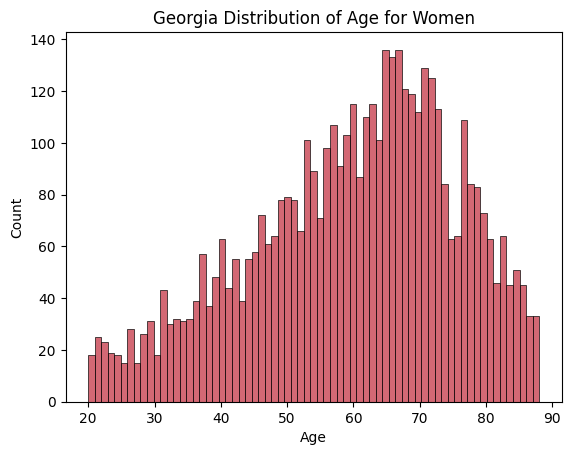

In [13]:
y_age_dist_female = y_filtered[y_filtered.Sex.values == 'Female'].Age.values.astype(int)
sn.histplot(y_age_dist_female, bins = 69, color="#C53645")
plt.ylabel('Count')
plt.xlabel('Age')
plt.title('Georgia Distribution of Age for Women')

Text(0.5, 1.0, 'Georgia Distribution of Age for Men')

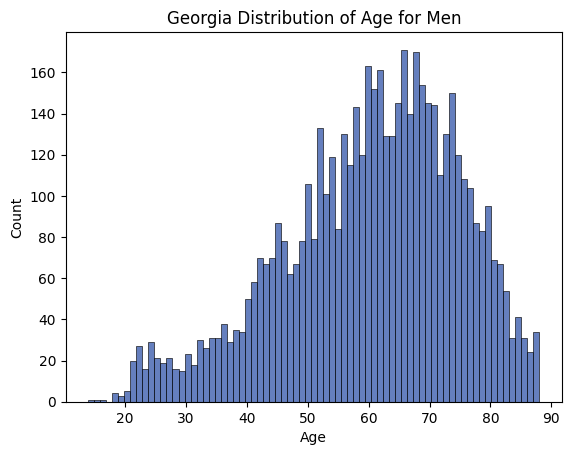

In [14]:
y_age_dist_male = y_filtered[y_filtered.Sex.values == 'Male'].Age.values.astype(int)
sn.histplot(y_age_dist_male, bins = 75, color="#3254a8")
plt.ylabel('Count')
plt.xlabel('Age')
plt.title('Georgia Distribution of Age for Men')

### Loading the Model

In [15]:
rnn_sex_model = tf.keras.models.load_model("../../saved_models/100hz/sex_models/rnn_sex_model_0.8310.h5")
cnn_lstm_model = tf.keras.models.load_model('../../saved_models/retrainers/age_model_retrainer/age_model_injected_100_4.27_0.91/')

In [16]:
def create_actuals(Y):
    actual_ages = Y.Age.values.astype(int)
    actual_sex = Y.Sex.values
    actual_sex[actual_sex == 'Male'] = 0
    actual_sex[actual_sex == 'Female'] = 1
    actual_sex = actual_sex.astype(int)
    return actual_ages, actual_sex

actual_ages, actual_sex = create_actuals(Y)

### XGBoost

### Classification Boost

In [17]:
def apply_boost_classification(model, layer_name, X, y):
    feature_extraction_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)


    # Extracting the features from the LSTM layer
    X_features = feature_extraction_model.predict(X) 

    # XGBoost picks off from these layers and applies its own algorithm
    xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1) 
    xgb_model.fit(X_features, y) 

    xgb_probs = xgb_model.predict_proba(X_features)[:, 1]
    model_probs = rnn_sex_model.predict(X)[:, 0]

    # I am taking the average of the prediction probabilities to get a balanced result
    combined_probs = xgb_probs
    combined_preds = np.where((np.squeeze(np.where(combined_probs >= 0.50, 1, 0))) == 1, 1, 0)

    # Returning both the probabilities and predictions
    return combined_probs, combined_preds

### Regression Boost

In [18]:
# rnn_sex_model = tf.keras.models.load_model("../saved_models/100hz/sex_models/rnn_sex_model_0.8310.h5")

def apply_boost_regression(model, layer_name, X, y):
    feature_extraction_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    # Extracting the features from the LSTM layer
    X_features = feature_extraction_model.predict(X)

    # XGBoost for regression
    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
    xgb_model.fit(X_features, y)

    xgb_preds = xgb_model.predict(X_features)
    model_preds = model.predict(X)
    
    # Combine the predictions using some kind of average or weighting
    combined_preds = (xgb_preds + model_preds) / 2.0

    # Returning the combined regression predictions
    return xgb_preds

### Model Choice

### Predictions

In [19]:
with tf.device('/CPU:0'):
    boosted_sex_prob, boosted_sex_preds = apply_boost_classification(rnn_sex_model, 'lstm_64', X_final, actual_sex)
    boosted_age_pred = apply_boost_regression(cnn_lstm_model, 'flatten', X_final, tf.cast(actual_ages, dtype=tf.int32))

316/316 [==============================] - 3s 6ms/step


In [20]:
# def predict_sex(model, X):
#     temp = model(tf.convert_to_tensor(X))
#     predicted_sex_prob = np.asarray(tf.squeeze(temp))
#     predicted_sex = np.where((np.squeeze(np.where(predicted_sex_prob >= 0.50, 1, 0))) == 1, 1, 0)
#     return predicted_sex_prob, predicted_sex


# def predict_age(model, X):
#     temp = model(tf.convert_to_tensor(X))
#     predicted_age = np.asarray(tf.squeeze(temp))
#     return predicted_age

# with tf.device('/CPU:0'):
#     predicted_age = predict_age(cnn_lstm_model, X_final)
#     predicted_sex_prob, predicted_sex = predict_sex(rnn_sex_model, X_final)

### Binning

In [21]:
# Function to bin the age values into age blocks
def bin_age(age):
    if age <18:
        return '<18'
    elif age >= 18 and age <= 25:
        return '18-25'
    elif age > 25 and age <= 49:
        return '25-49'
    elif age > 49 and age <= 75:
        return '50-75'
    else:
        return '75+'

### Evaluation Metrics

#### MAE and RMSE for Age

In [22]:
from sklearn.metrics import mean_absolute_error,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error

mean_absolute_error(actual_ages, boosted_age_pred), mean_squared_error(actual_ages, boosted_age_pred)**0.5

(6.907454168238317, 8.715575007189303)

#### Accuracy For Sex

In [23]:
accuracy_score(actual_sex, boosted_sex_preds)

0.837045837045837

### AUC for Sex prediction

In [24]:
from sklearn.metrics import roc_auc_score

roc_auc_score(actual_sex, boosted_sex_preds)

0.8353916706264746

### R-Squared for Age Prediction

In [25]:
from sklearn.metrics import r2_score
r2_score(actual_ages, boosted_age_pred)

0.6716172541244687

### F-1 Sex

In [26]:
from sklearn.metrics import f1_score
f1_score(actual_sex, boosted_sex_preds)

0.8214750542299349

### F1 for Age

In [27]:
# Assuming y_test contains the actual age values and y_pred contains the predicted age values
# Create the actual age blocks
y_test_blocks = np.array([bin_age(age) for age in actual_ages])

# Create the predicted age blocks
y_pred_blocks = np.array([bin_age(age) for age in boosted_age_pred])

f1_score(y_test_blocks, y_pred_blocks, average = 'micro')

0.7117117117117117

### Viz Functions

In [28]:
def age_bar(actual, predicted, title):
    # Create a DataFrame from the data
    data = pd.DataFrame({'Category': np.squeeze(actual), 'Values': np.squeeze(predicted)})

    # Get the unique categories sorted in ascending order and their counts
    category_counts = data['Category'].value_counts().sort_index()

    # Create labels that include the category and its count
    x_tick_labels = [f"{cat} (n={count})" for cat, count in category_counts.items()]

    # Create a color palette based on the counts, dark blue to dark red (lowest to highest)
    max_count = category_counts.max()
    palette = [sn.color_palette("coolwarm", n_colors=10)[min(int(10 * count / max_count), 9)] for count in category_counts]

    plt.figure(figsize=(25, 7))
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    sn.boxplot(x='Category', y='Values', data=data, width=0.6, palette=palette)
    category_positions = range(len(category_counts))
    plt.scatter(category_positions, np.unique(np.squeeze(actual)), color='black', label='Actual', alpha=0.7)    
    plt.xlabel('Actual Age', fontsize=18)
    plt.ylabel('Predicted Age', fontsize=18)
    
    plt.xticks(range(len(x_tick_labels)), x_tick_labels, fontsize=15, rotation=45)  # Adjust rotation for readability
    
    plt.yticks(range(0, 135, 5), fontsize=15)
    plt.title(title, fontsize=21)
    plt.show()


In [29]:
def category_boxplot(categories, values, title, xlabel='Age Group', ylabel='Age Predictions', category_order=None):
    data = pd.DataFrame({xlabel: categories, ylabel: values})
    
    if category_order:
        data[xlabel] = pd.Categorical(data[xlabel], categories=category_order, ordered=True)

    plt.figure(figsize=(12, 6))
    sn.boxplot(x=xlabel, y=ylabel, data=data, width=0.6, order=category_order)
    
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel(ylabel, fontsize = 15)
    plt.title(title, fontsize =20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    # Show the plot
    plt.show()

In [30]:
import seaborn as sns   # Remeber to install seaborn

def cat_plot(actual, predicted):
    data = pd.DataFrame({'Category': np.squeeze(actual), 'Values': np.squeeze(predicted)})  # Merges the Actual and predicted data
    sns.catplot(x='Category', y='Values', data=data, order=['18-25', '25-49', '50-75', '75+'])   # Takes the unique values for X and plots them with all associated Y values. Thus a boxplot range is produced



In [31]:
import itertools
from sklearn.metrics import confusion_matrix

figsize = (10, 10)

def make_confusion_matrix(y_actual, y_pred, classes=None, figsize=(10, 10), text_size=15):
    cm = confusion_matrix(y_actual, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    labels = classes if classes else np.arange(cm.shape[0])
    ax.set(title="Confusion Matrix On Testing Dataset",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ax.set_xlabel("Predicted label", fontsize=text_size)
    ax.set_ylabel("True label", fontsize=text_size)
    ax.set_title("Confusion Matrix", fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), repeat=2):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)

    plt.show()


In [32]:
def category_boxplot(categories, values, title, xlabel='Age Group', ylabel='Age Predictions', category_order=None):
    data = pd.DataFrame({xlabel: categories, ylabel: values})
    
    if category_order:
        data[xlabel] = pd.Categorical(data[xlabel], categories=category_order, ordered=True)

    plt.figure(figsize=(12, 6))
    sns.boxplot(x=xlabel, y=ylabel, data=data, width=0.6, order=category_order)
    
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel(ylabel, fontsize = 15)
    plt.title(title, fontsize =20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    # Show the plot
    plt.show()

def cat_plot(actual, predicted):
    data = pd.DataFrame({'Category': np.squeeze(actual), 'Values': np.squeeze(predicted)})  # Merges the Actual and predicted data
    sns.catplot(x='Category', y='Values', data=data, order=['18-25', '25-49', '50-75', '75+'])   # Takes the unique values for X and plots them with all associated Y values. Thus a boxplot range is produced

figsize = (10, 10)

def make_confusion_matrix(y_actual, y_pred, classes=None, figsize=(10, 10), text_size=15):
    cm = confusion_matrix(y_actual, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    labels = classes if classes else np.arange(cm.shape[0])
    ax.set(title="Confusion Matrix On Testing Dataset",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ax.set_xlabel("Predicted label", fontsize=text_size)
    ax.set_ylabel("True label", fontsize=text_size)
    ax.set_title("Confusion Matrix", fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), repeat=2):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)

    plt.show()

In [33]:
def age_cf(actual_blocks, predicted_blocks, title):
    # Compute the confusion matrix
    cm = confusion_matrix(actual_blocks, predicted_blocks, labels=['18-25', '25-49', '50-75', '75+'])

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a heatmap of the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['18-25', '25-49', '50-75', '75+'], yticklabels=['18-25', '25-49', '50-75', '75+'])
    plt.xlabel('Predicted Age Block')
    plt.ylabel('Actual Age Block')
    plt.title(title)
    plt.show()

In [34]:
def age_bar_categorizer(actual, predicted, Y, title, category_column):
    unique_categories = Y[category_column].unique()

    for category_value in unique_categories:
        predicted_category = predicted[Y[category_column] == category_value]
        actual_category = actual[Y[category_column] == category_value]

        age_bar(actual_category, predicted_category, title=f'{title} - {category_value}')

def age_cf_categorizer(actual, predicted, Y, title, category_column):
    unique_categories = Y[category_column].unique()

    for category_value in unique_categories:
        predicted_category = predicted[Y[category_column] == category_value]
        actual_category = actual[Y[category_column] == category_value]

        make_confusion_matrix(actual_category, predicted_category, classes=None, figsize=(10, 10), text_size=15)

def age_blocked_cf_categorizer(actual, predicted, Y, title, category_column):
    unique_categories = Y[category_column].unique()

    for category_value in unique_categories:
        predicted_category = predicted[Y[category_column].values == category_value]
        actual_category = actual[Y[category_column].values == category_value]
    
        age_actual_blocked = np.array([bin_age(age) for age in actual_category])
        age_pred_blocked = np.array([bin_age(age) for age in predicted_category])
        age_cf(age_actual_blocked, age_pred_blocked, title=f'{title} - {category_value}')
    
def age_blocked_cf(actual, predicted, Y, title):
    age_actual_blocked = np.array([bin_age(age) for age in actual])
    age_pred_blocked = np.array([bin_age(age) for age in predicted])
    age_cf(age_actual_blocked, age_pred_blocked, title)

In [35]:
def merged_hist_boxplot(actual_age, boxplot_predicted, hist_bins, hist_color, title):
    # Create a DataFrame for the boxplot data
    boxplot_data = pd.DataFrame({'Category': np.squeeze(actual_age), 'Values': np.squeeze(boxplot_predicted)})

    # Create the base figure and primary axis for the histogram
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Plotting the histogram using matplotlib
    n, bins, patches = ax1.hist(actual_age, bins=hist_bins, color=hist_color, alpha=0.2)
    ax1.set_xlabel('Age')
    ax1.set_ylabel('Count (Histogram)', color=hist_color)
    ax1.tick_params(axis='y', labelcolor=hist_color)

    # Adding labels at the bottom of each bar
    bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Calculate the center of each bin
    for count, x in zip(n, bin_centers):
        # Only put labels on bars with counts greater than zero to avoid clutter
        if count > 0:
            ax1.text(x, 0, str(int(x)), rotation=90, ha='center', va='bottom')

    ax1.set_xlim(left=13.5, right=actual_age.max())

    ax2 = ax1.twinx()
    sns.boxplot(x='Category', y='Values', data=boxplot_data, ax=ax2, width=0.6)
    ax2.set_ylabel('Values (Boxplot)')
    ax2.tick_params(axis='y')

    plt.title(title)

    plt.tight_layout()

    plt.show()

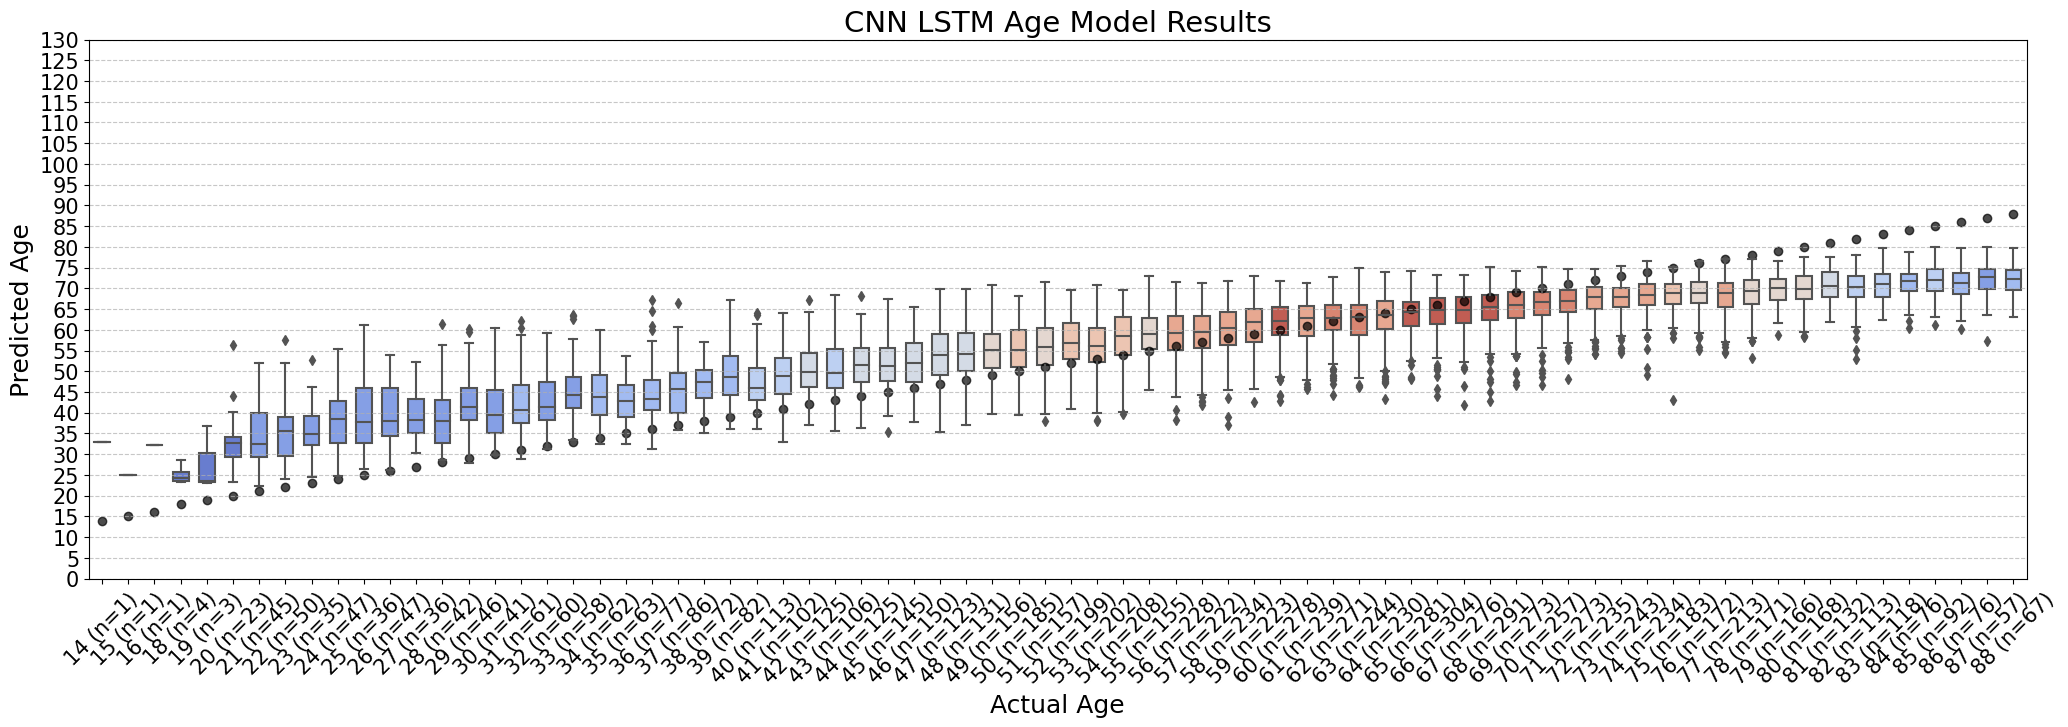

In [36]:
age_bar(actual_ages, boosted_age_pred, title = "CNN LSTM Age Model Results")

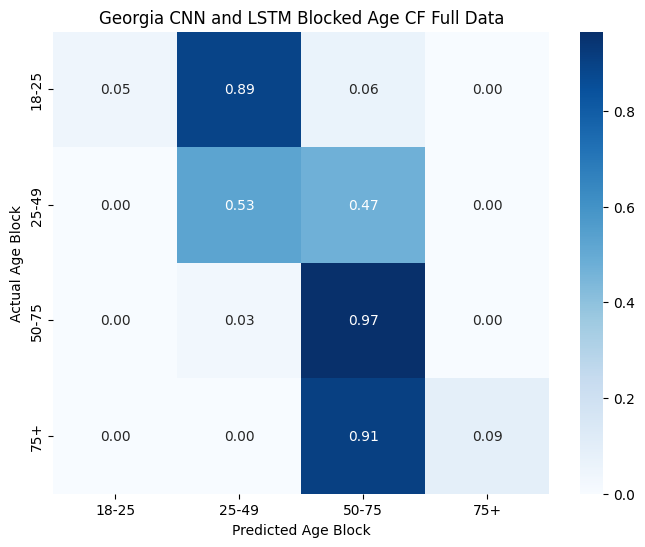

In [37]:
age_blocked_cf(actual_ages, boosted_age_pred, Y, title = "Georgia CNN and LSTM Blocked Age CF Full Data")

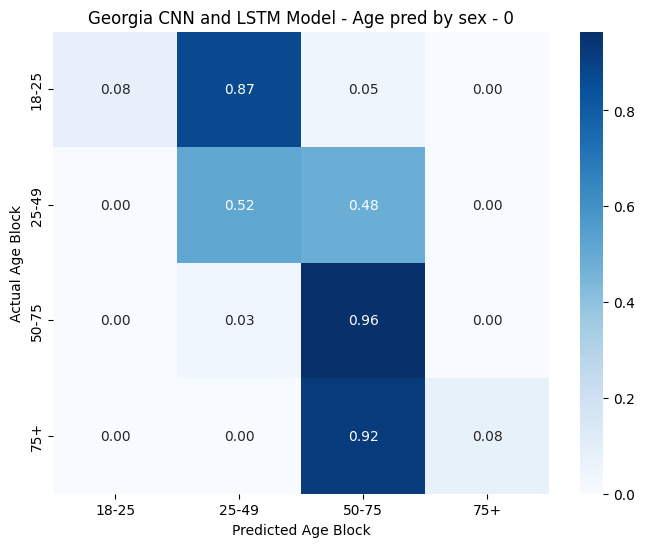

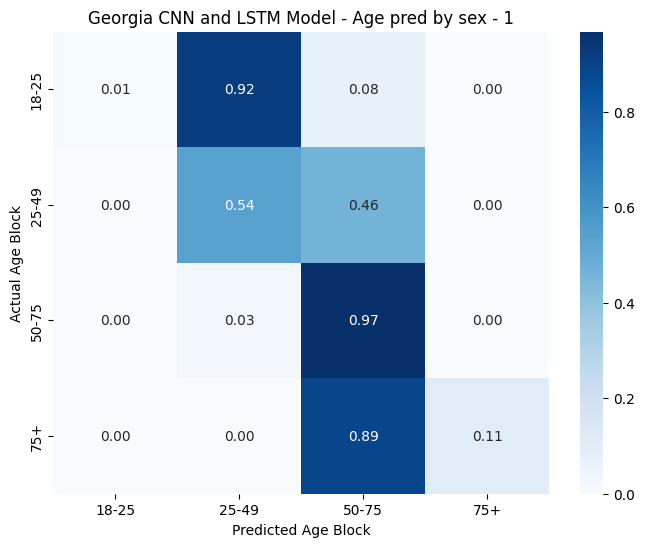

In [38]:
age_blocked_cf_categorizer(actual_ages, boosted_age_pred, Y, title = "Georgia CNN and LSTM Model - Age pred by sex", category_column = 'Sex')

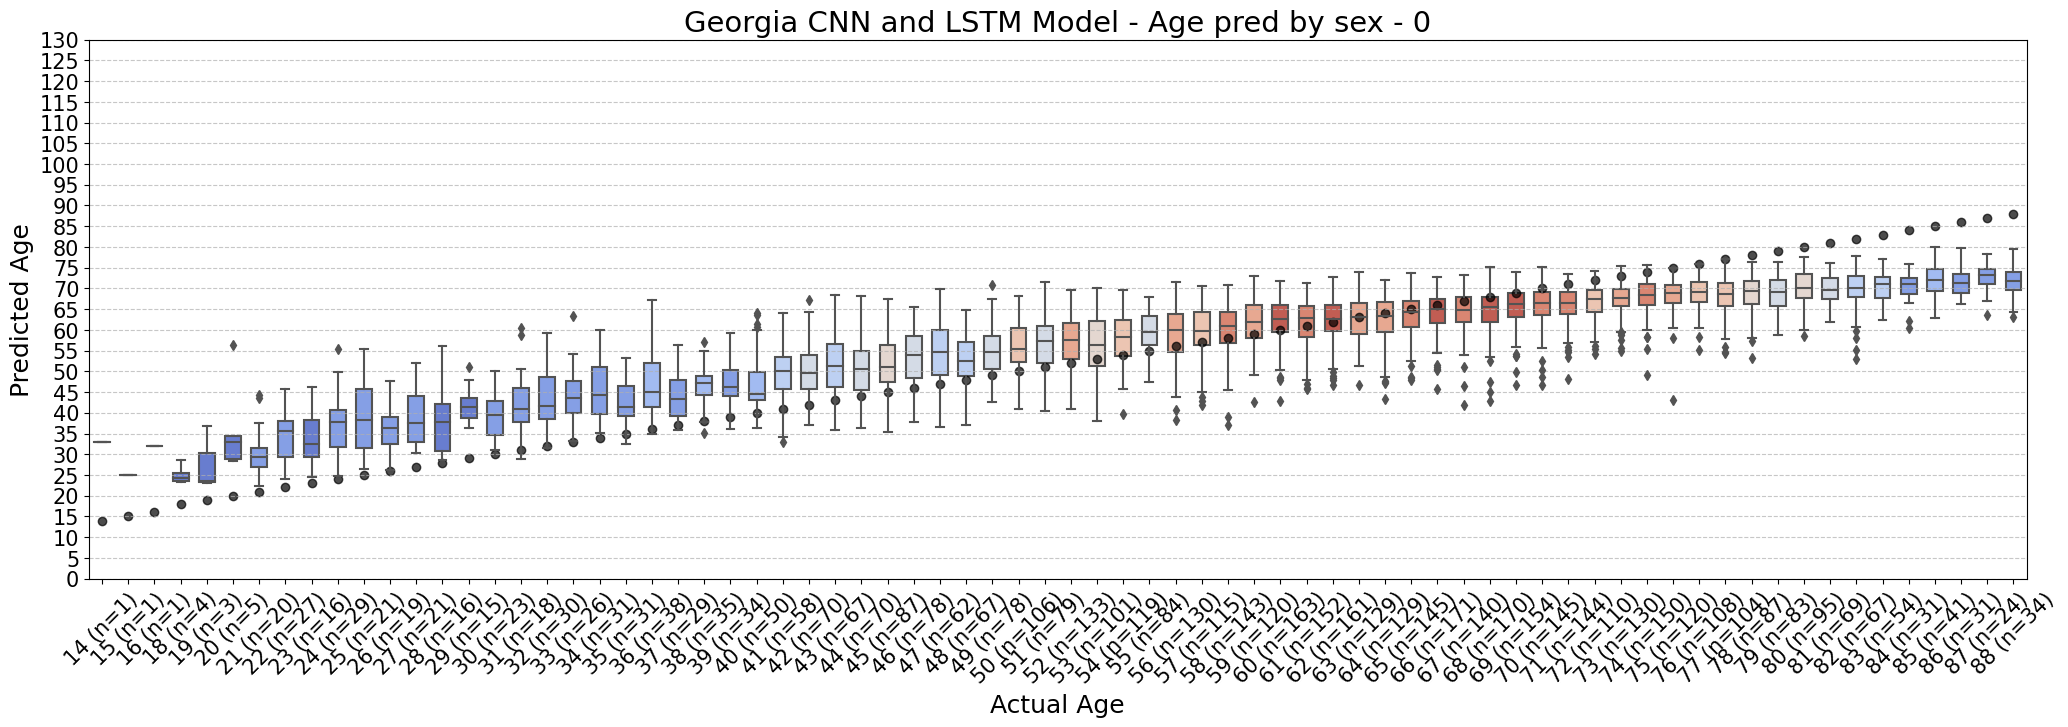

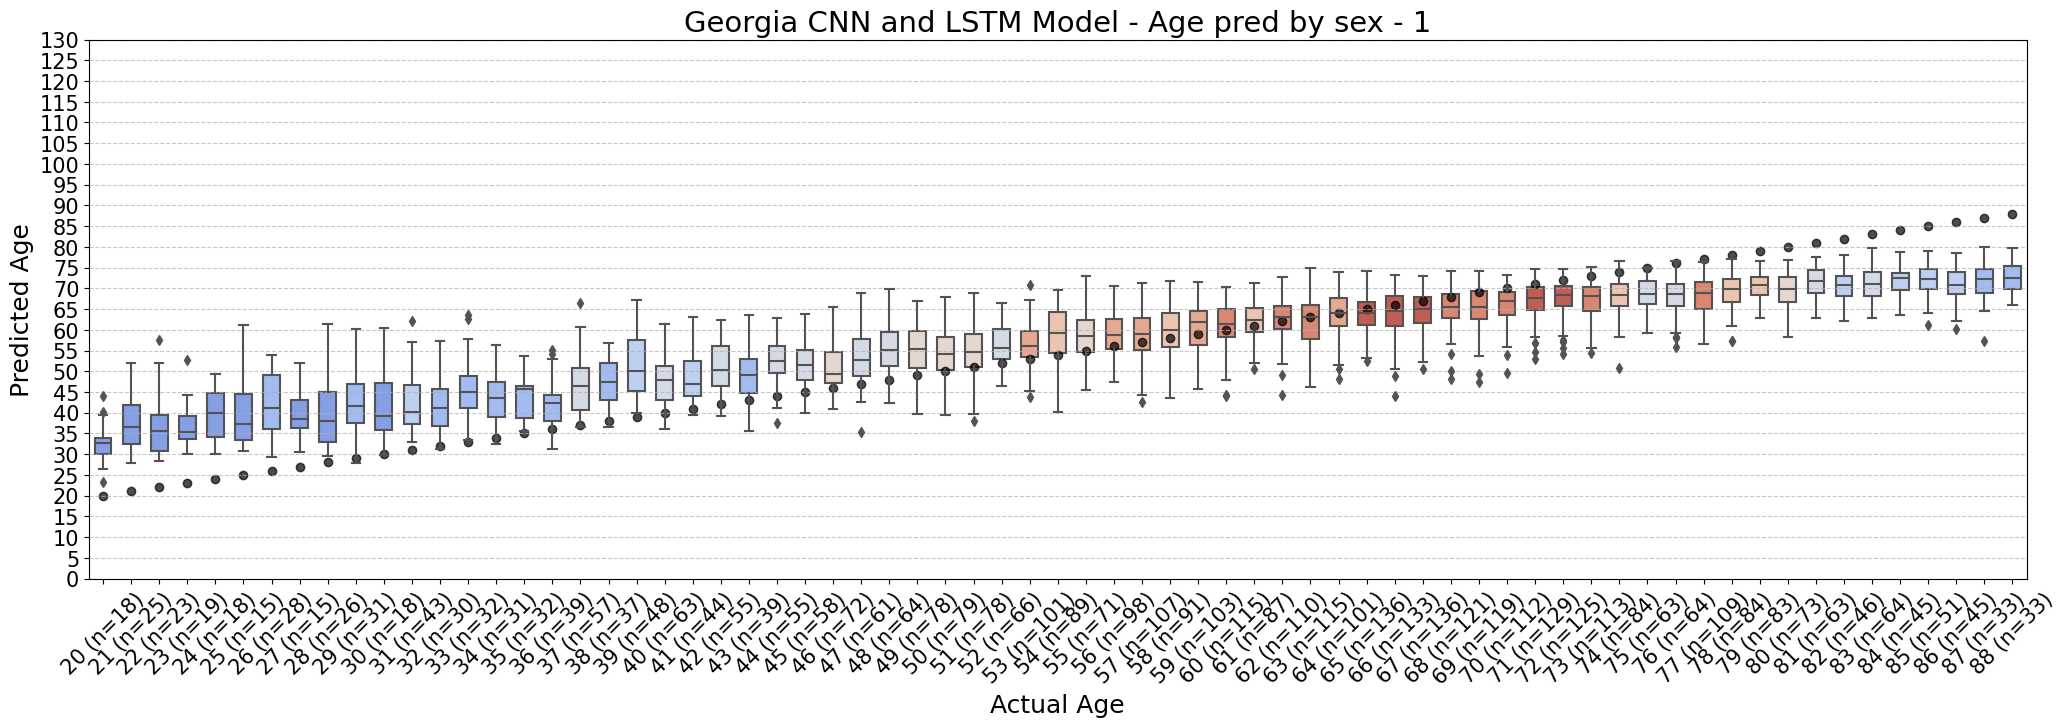

In [39]:
age_bar_categorizer(actual_ages, boosted_age_pred, Y, title = "Georgia CNN and LSTM Model - Age pred by sex", category_column = 'Sex')

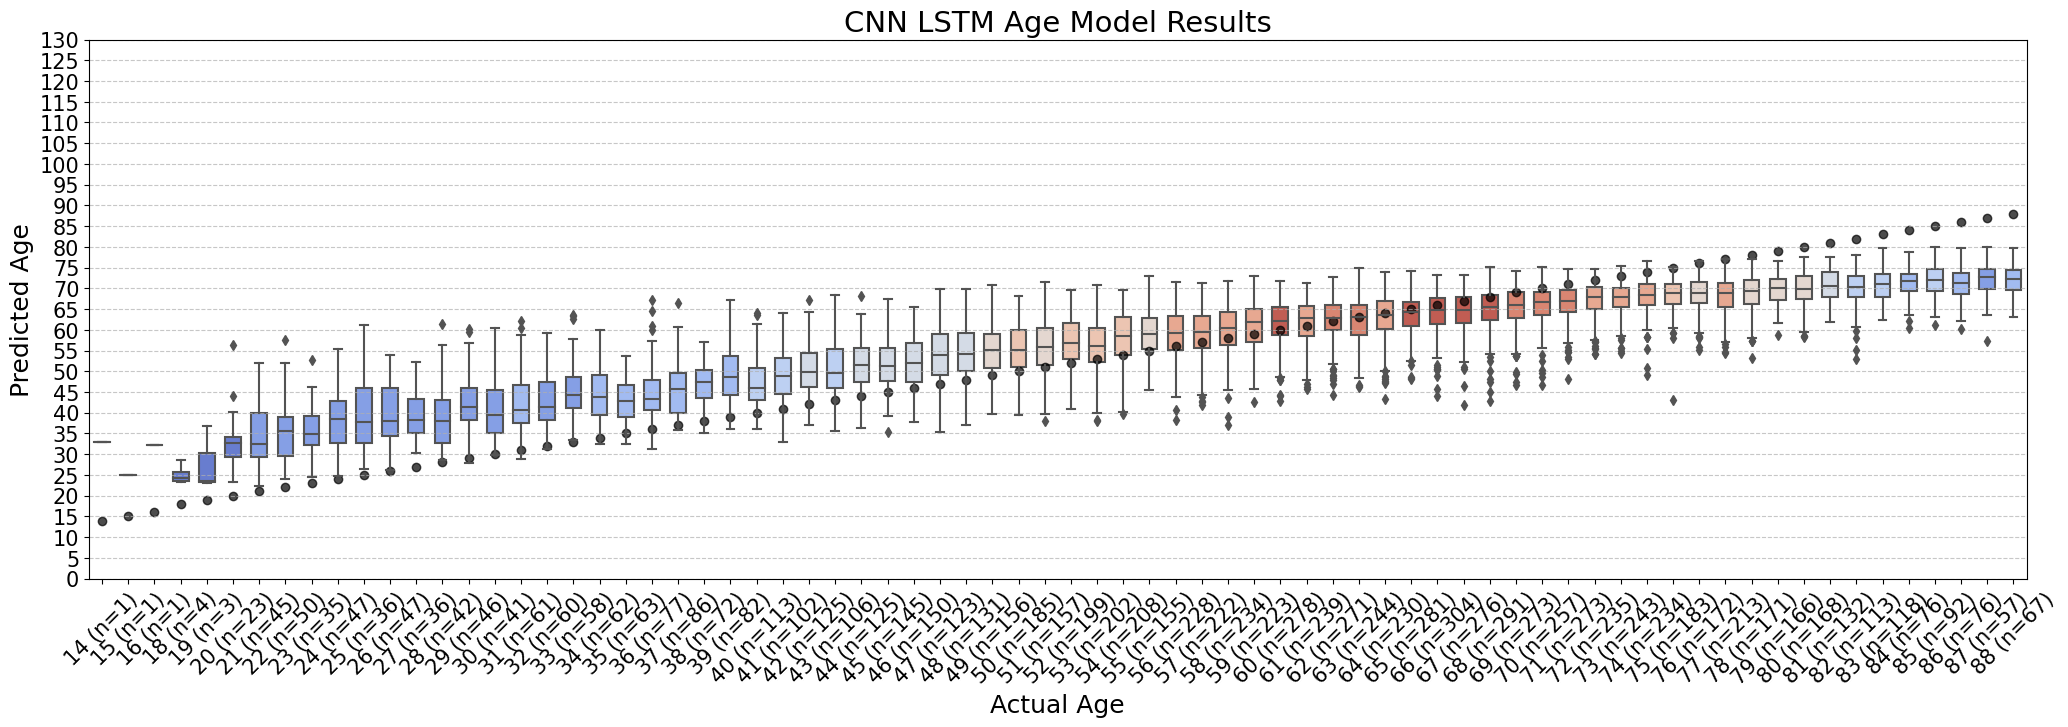

In [40]:
age_bar(actual_ages, boosted_age_pred, title = "CNN LSTM Age Model Results")

In [41]:
count = 0
for i in y_test_blocks:
    if i == '50-75':
        count = count + 1
print(count)

6125


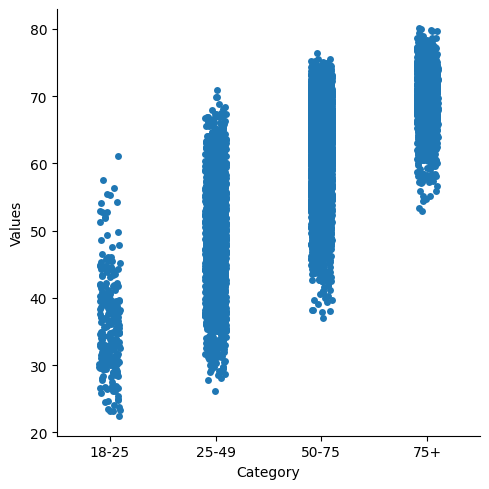

In [42]:
cat_plot(y_test_blocks, boosted_age_pred)

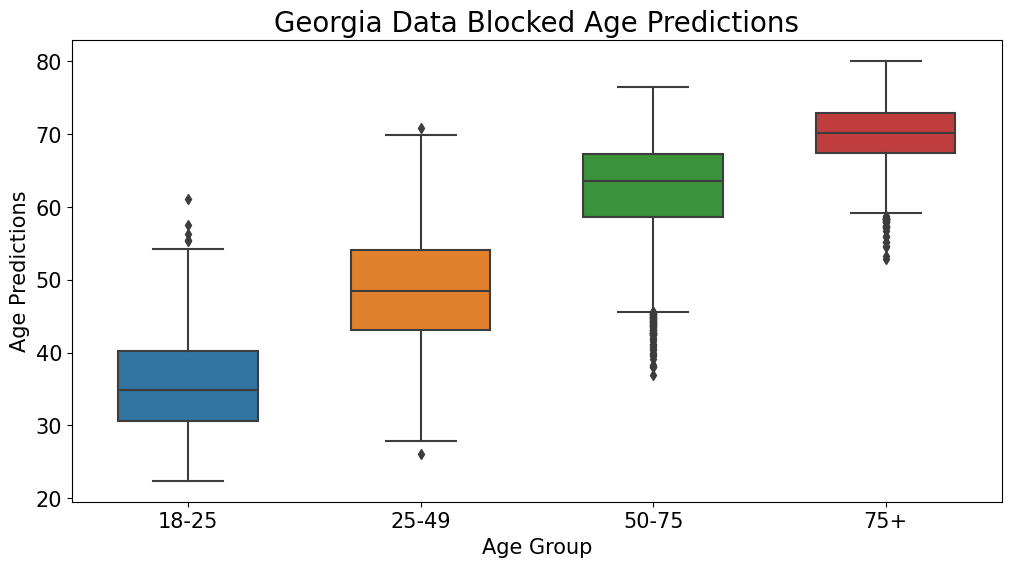

In [43]:
category_boxplot(y_test_blocks, boosted_age_pred, title = "Georgia Data Blocked Age Predictions", category_order = ['18-25', '25-49', '50-75', '75+'])

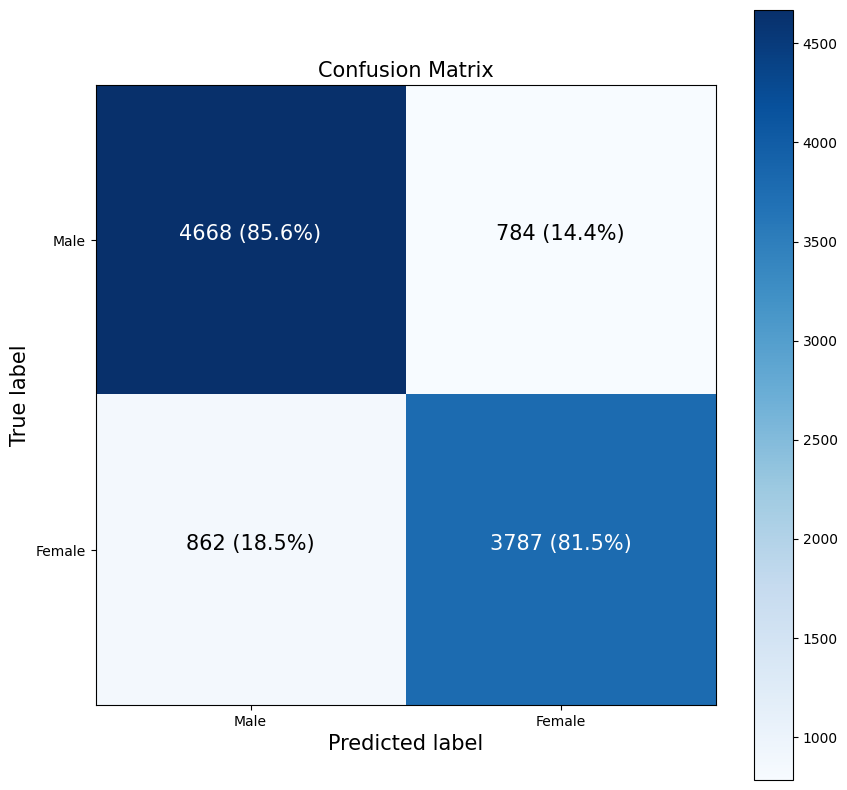

In [44]:
make_confusion_matrix(actual_sex, boosted_sex_preds, ['Male', 'Female'])

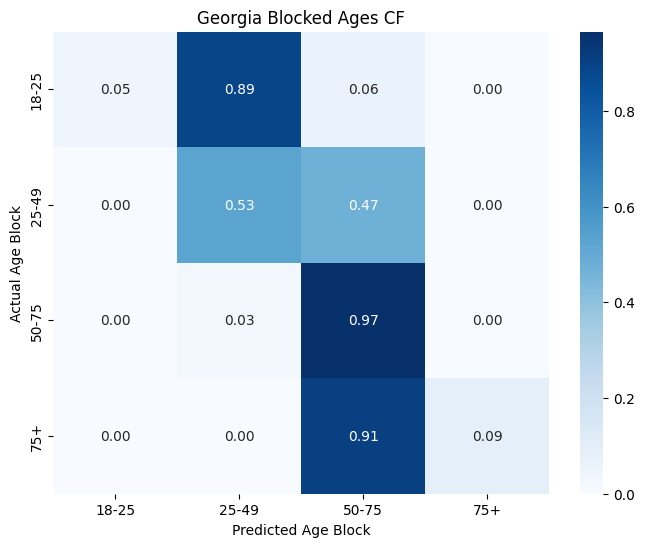

In [45]:

# Compute the confusion matrix
cm = confusion_matrix(y_test_blocks, y_pred_blocks, labels=['18-25', '25-49', '50-75', '75+'])

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['18-25', '25-49', '50-75', '75+'], yticklabels=['18-25', '25-49', '50-75', '75+'])
plt.xlabel('Predicted Age Block')
plt.ylabel('Actual Age Block')
plt.title('Georgia Blocked Ages CF')
plt.show()


#### Sampling examples

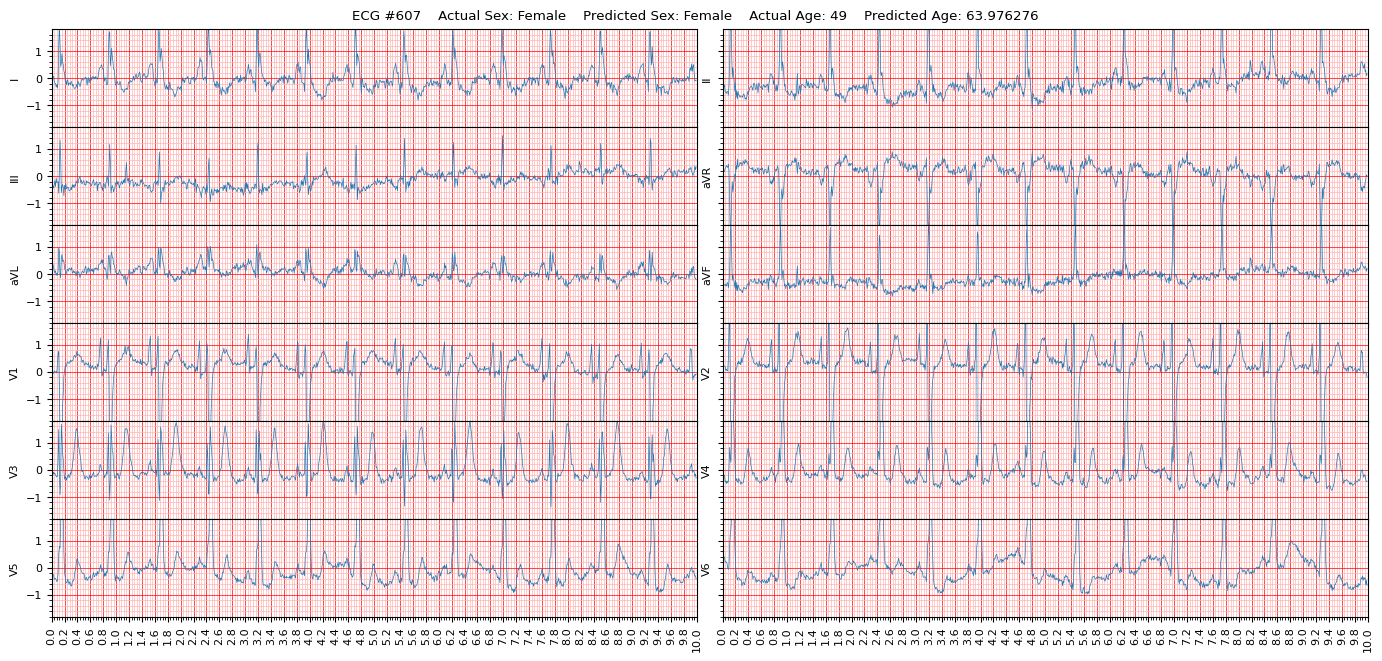

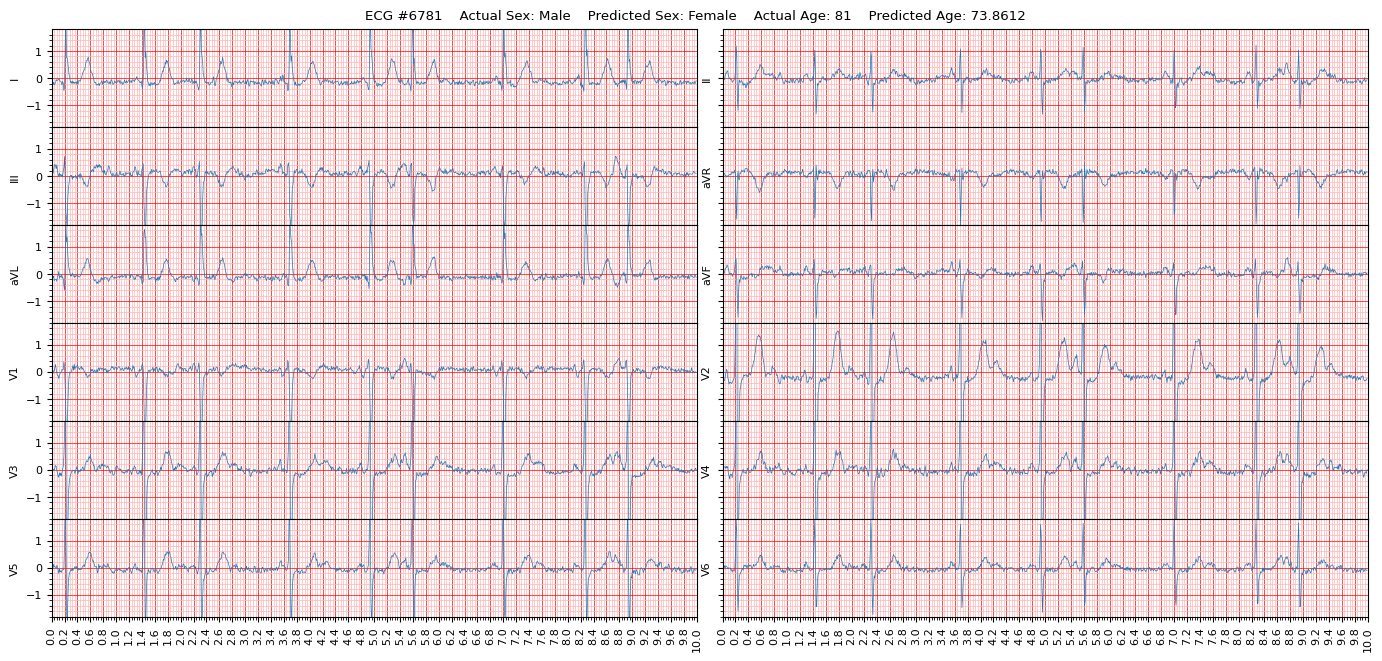

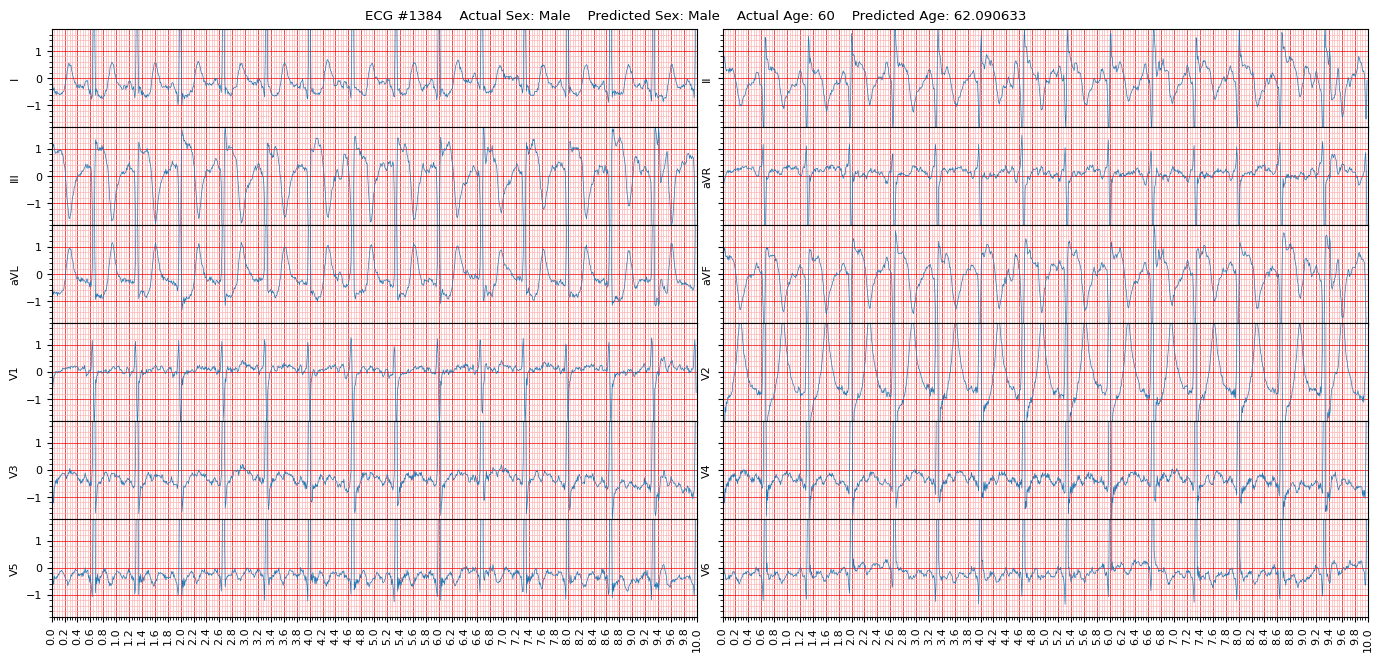

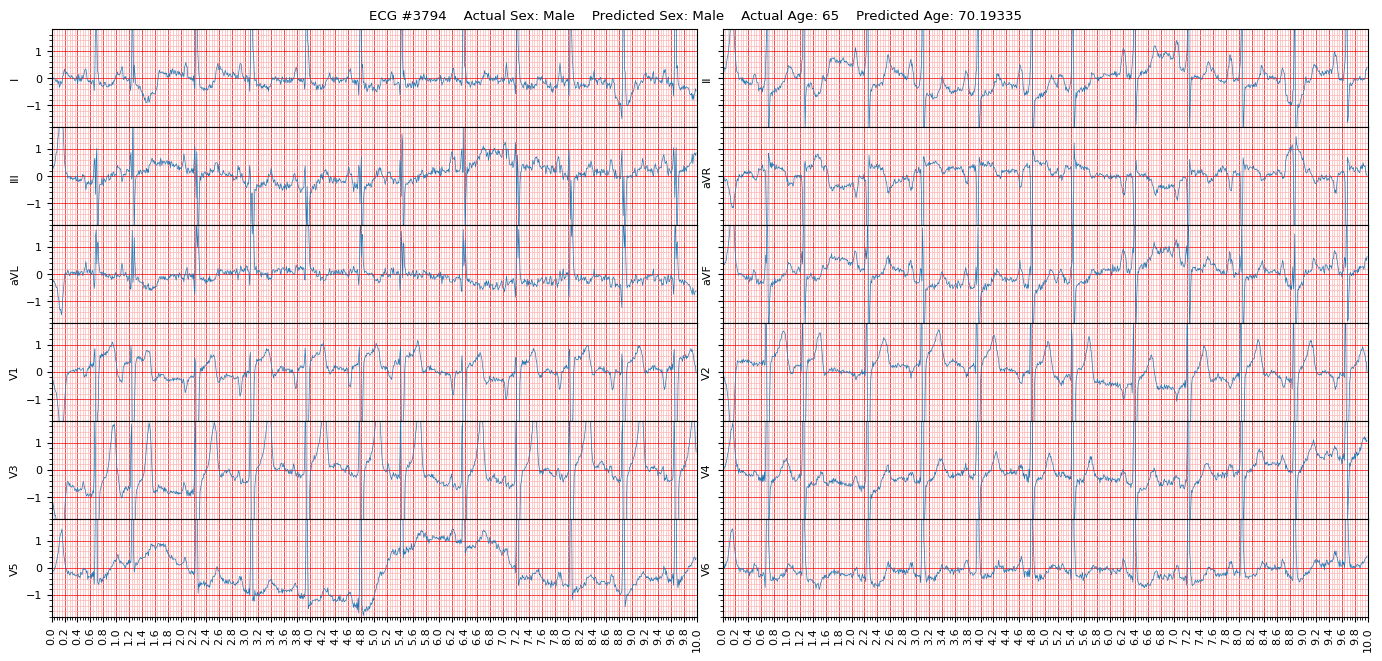

In [46]:
from random import choice

def visualize(X, actual_1, actual_2, predicted_1, predicted_2):
    class_names = ['Male', 'Female']
    for i in range(4):
        ind = choice(range(1, len(X)))
        plot_title = ("ECG #" + str(ind) + "    Actual Sex: " + str(class_names[actual_1[ind]]) + "    Predicted Sex: " + str(class_names[predicted_1[ind]])  +
                      "    Actual Age: " + str(actual_2[ind]) + "    Predicted Age: " + str(predicted_2[ind]))
        ecg_plot.plot_12(tf.transpose(X, (0,2,1))[ind], sample_rate=100, title = plot_title)

with tf.device("/CPU:0"):
    visualize(X_final, actual_sex, actual_ages, boosted_sex_preds, boosted_age_pred)